# Decision Tree for the Weather Dataset
We are going to compute the decision tree for the weather dataset. The Scikit-learn cannot deal with categorical attributes thus we need to transform the weather dataset into a numerical representation. Previously, we used the One-Hot-Encoding. In this session we are going to compare the result produced by the one-hot-encoding with the basic numerical transformation of categorical attributs into numerical attributes.

First, we import all the libraries we need.

In [1]:
# general-purpose libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scikit-Learn
import sklearn
from sklearn import linear_model
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve,roc_auc_score,precision_score,recall_score,auc


# libraries needed to plot decision trees
import io
import pydot
from scipy import misc
%matplotlib inline

We also define a function we will use to export decision trees as images

In [2]:
def visualize_decision_tree(decision_tree, feature_names, image):
    """Create tree png using graphviz.

    Args
    ----
    decision_tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    image -- file containing the final image
    """

    dotfile = io.StringIO()
    sklearn.tree.export_graphviz(decision_tree, feature_names=feature_names, out_file=dotfile, filled=True, rounded=True, special_characters=True)
    pydot.graph_from_dot_data(dotfile.getvalue())[0].write_png(image)

Next, we load the dataset.

In [3]:
weather = pd.read_csv('Weather.csv')
weather.head(5)

,Outlook,Temperature,Humidity,Windy,Play
0,sunny,hot,high,False,no
1,sunny,hot,high,True,no
2,overcast,hot,high,False,yes
3,rainy,mild,high,False,yes
4,rainy,cool,normal,False,yes


In [4]:
target = 'Play'
variables = weather.columns[weather.columns!=target]

We define the class attribute by encoding the Play attribute as a +1/-1 attribute

In [5]:
weather['Class'] = weather[target].apply(lambda x: 1 if x=='yes' else -1);
weather = weather.drop(target,axis=1);
numerical_target = 'Class'

We now map the categorical/nominal variables into 0/1 variables using one-hot-encoding approach

In [6]:
weather_binary = pd.get_dummies(weather, columns=variables)
weather_binary.head()

,Class,Outlook_overcast,Outlook_rainy,Outlook_sunny,Temperature_cool,Temperature_hot,Temperature_mild,Humidity_high,Humidity_normal,Windy_False,Windy_True
0,-1,0,0,1,0,1,0,1,0,1,0
1,-1,0,0,1,0,1,0,1,0,0,1
2,1,1,0,0,0,1,0,1,0,1,0
3,1,0,1,0,0,0,1,1,0,1,0
4,1,0,1,0,1,0,0,0,1,1,0


In [7]:
binary_variables = weather_binary.columns[weather_binary.columns!=numerical_target]

We repeat the same process but this time we are going to simply map categorical values into numbers using the tools provided by the Scikit-learn library.

In [8]:
weather_dict = {}
numerical_variables = weather.columns[weather.columns!=target]

# keep all the label encoders used
label_encoders = {}

for v in numerical_variables:
    label_encoders[v] = preprocessing.LabelEncoder()
    label_encoders[v].fit(weather[v])
    weather_dict[v] = label_encoders[v].transform(weather[v])

weather_numerical = pd.DataFrame(weather_dict)
weather_numerical['Class'] = weather['Class']

weather_numerical.head(5)

,Class,Humidity,Outlook,Temperature,Windy
0,-1,0,2,1,0
1,-1,0,2,1,1
2,1,0,0,1,0
3,1,0,1,2,0
4,1,1,1,0,0


In [9]:
x_bin = weather_binary[binary_variables]
x_num = weather_numerical[numerical_variables]

Now we can apply a decision tree classifier to the two versions of the dataset using entropy as the splitting criteria.

In [10]:
y = weather_binary['Class'] 

dt_bin = dt = tree.DecisionTreeClassifier('entropy')
dt_bin = dt_bin.fit(x_bin, y)
xval_bin = model_selection.cross_val_score(dt_bin, x_bin, y, cv=KFold(n_splits=10, shuffle=True, random_state=1234))

dt_num = tree.DecisionTreeClassifier('entropy')
dt_num = dt_num.fit(x_num, y)
xval_num = model_selection.cross_val_score(dt_num, x_num, y, cv=KFold(n_splits=10, shuffle=True, random_state=1234))

print("Entropy - One-Hot-Encoding   Avg Accuract=%3.2f +/- %3.2f"%(np.average(xval_bin),np.std(xval_bin)))
print("Entropy - Numerical Encoding Avg Accuract=%3.2f +/- %3.2f"%(np.average(xval_num),np.std(xval_num)))

Entropy - One-Hot-Encoding   Avg Accuract=0.55 +/- 0.42
Entropy - Numerical Encoding Avg Accuract=1.00 +/- 0.00


## Question
- Are these performances satisfactory?
- What do the high values of standard deviation suggest?
- What might cause them?

Let's plot the decision tree for the one-hot-encoding and for the numerical encoding.

/Users/pierluca/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


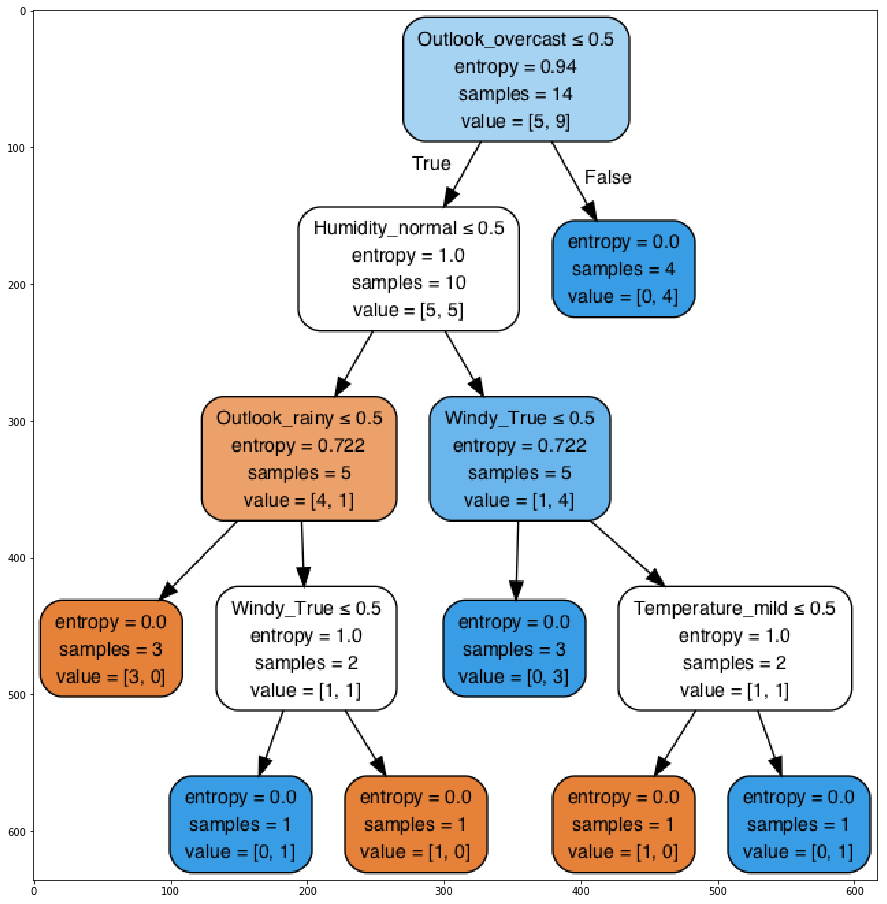

In [11]:
visualize_decision_tree(dt_bin, x_bin.columns, 'weather_num_gini.png')
i = misc.imread('weather_num_gini.png')
plt.figure(1, figsize=(24, 16))
plt.imshow(i);

/Users/pierluca/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


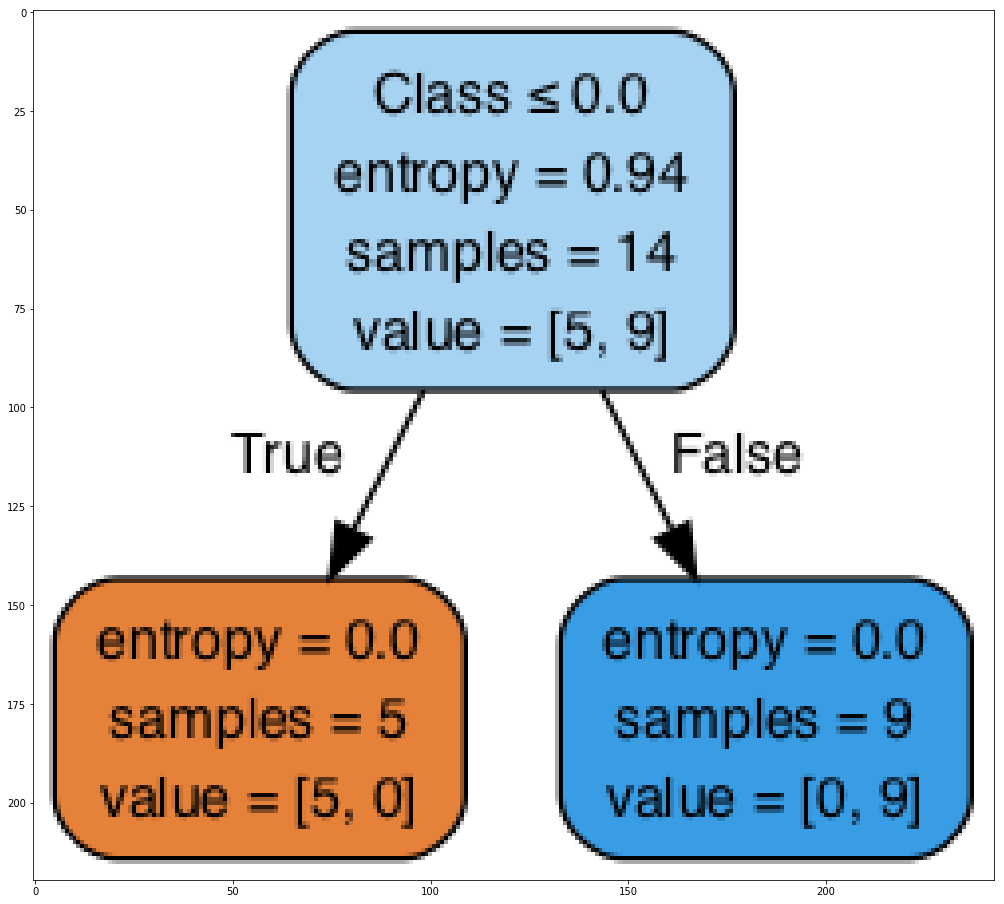

In [12]:
visualize_decision_tree(dt_num, x_num.columns, 'weather_num_gini.png')
i = misc.imread('weather_num_gini.png')
plt.figure(1, figsize=(24, 16))
plt.imshow(i);

Finally, let's compute the decision trees using the same datasets and the gini index (it is actually the default option). 

In [13]:
x_bin = weather_binary[binary_variables]
x_num = weather_numerical[numerical_variables]

y = weather_binary[numerical_target] 

dt_bin_gini = tree.DecisionTreeClassifier('gini')
dt_bin_gini = dt_bin_gini.fit(x_bin, y)
xval_bin_gini = model_selection.cross_val_score(dt_bin_gini, x_bin, y, cv=KFold(n_splits=10, shuffle=True, random_state=1234))


dt_num_gini = tree.DecisionTreeClassifier('gini')
dt_num_gini = dt_num_gini.fit(x_num, y)
xval_num_gini = model_selection.cross_val_score(dt_num_gini, x_num, y, cv=KFold(n_splits=10, shuffle=True, random_state=1234))

print("Gini - One-Hot-Encoding   Avg Accuract=%3.2f +/- %3.2f"%(np.average(xval_bin_gini),np.std(xval_bin_gini)))
print("Gini - Numerical Encoding Avg Accuract=%3.2f +/- %3.2f"%(np.average(xval_num_gini),np.std(xval_num_gini)))

Gini - One-Hot-Encoding   Avg Accuract=0.60 +/- 0.37
Gini - Numerical Encoding Avg Accuract=1.00 +/- 0.00
